In [56]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from mlmicrophysics.models import DenseNeuralNetwork
from sklearn.ensemble import RandomForestClassifier
from mlmicrophysics.data import subset_data_files_by_date, log10_transform, neg_log10_transform
from sklearn.preprocessing import StandardScaler, RobustScaler, MaxAbsScaler, MinMaxScaler
from sklearn.metrics import r2_score, confusion_matrix, mean_squared_error
from keras.models import save_model
from matplotlib.colors import LogNorm
scalers = {"MinMaxScaler": MinMaxScaler,
           "MaxAbsScaler": MaxAbsScaler,
           "StandardScaler": StandardScaler,
           "RobustScaler": RobustScaler}
transforms = {"log10_transform": log10_transform,
              "neg_log10_transform": neg_log10_transform}

In [7]:
#path = "/glade/scratch/dgagne/cam_mp_files_run2_csv/"
path = "/Users/dgagne/data/cam_mp_files_run2_csv/"
train_files, val_files, test_files = subset_data_files_by_date(path, ".csv", train_date_start=0, train_date_end=8000, 
                                                               test_date_start=8100, test_date_end=16000)

[    0   123   246   369   492   615   738   861   984  1107  1230  1353
  1476  1599  1722  1845  1968  2091  2214  2337  2460  2583  2706  2829
  2952  3075  3198  3321  3444  3567  3690  3813  3936  4059  4182  4305
  4428  4551  4674  4797  4920  5043  5166  5289  5412  5535  5658  5781
  5904  6027  6150  6273  6396  6519  6642  6765  6888  7011  7134  7257
  7380  7503  7626  7749  7872  7995  8118  8241  8364  8487  8610  8733
  8856  8979  9102  9225  9348  9471  9594  9717  9840  9963 10086 10209
 10332 10455 10578 10701 10824 10947 11070 11193 11316 11439 11562 11685
 11808 11931 12054 12177 12300 12423 12546 12669 12792 12915 13038 13161
 13284 13407 13530 13653 13776 13899 14022 14145 14268 14391 14514 14637
 14760 14883 15006 15129 15252 15375 15498 15621 15744 15867 15990 16113
 16236 16359 16482 16605 16728 16851 16974 17097 17220 17343 17466]


In [8]:
input_cols = ["pressure", "temperature", "RHO_CLUBB_lev", "RHO_CLUBB_top", "RHO_CLUBB_bottom",
             "QC_TAU_in", "NC_TAU_in", "QR_TAU_in", "NR_TAU_in",]
output_cols = ["qctend_TAU", "qrtend_TAU", "nctend_TAU", "nrtend_TAU", "qctend_MG2", "qrtend_MG2", "nctend_MG2", "nrtend_MG2"]
all_input_data = []
all_output_data = []
subsample= 0.1
for filename in train_files:
    print(filename)
    data = pd.read_csv(filename, index_col="Index")
    data = data.loc[data["NC_TAU_in"] >= 10].reset_index()
    sample_index = int(np.round(data.shape[0] * subsample))
    sample_indices = np.sort(np.random.permutation(np.arange(data.shape[0]))[:sample_index])
    all_input_data.append(data.loc[sample_indices, input_cols])
    all_output_data.append(data.loc[sample_indices, output_cols])
    del data
print("Combining data")
combined_input_data = pd.concat(all_input_data, ignore_index=True)
combined_output_data = pd.concat(all_output_data, ignore_index=True)
del all_input_data[:]
del all_output_data[:]

/Users/dgagne/data/cam_mp_files_run2_csv/cam_mp_data_run2_000123.csv
/Users/dgagne/data/cam_mp_files_run2_csv/cam_mp_data_run2_000246.csv
/Users/dgagne/data/cam_mp_files_run2_csv/cam_mp_data_run2_000492.csv
/Users/dgagne/data/cam_mp_files_run2_csv/cam_mp_data_run2_000615.csv
/Users/dgagne/data/cam_mp_files_run2_csv/cam_mp_data_run2_000861.csv
/Users/dgagne/data/cam_mp_files_run2_csv/cam_mp_data_run2_000984.csv
/Users/dgagne/data/cam_mp_files_run2_csv/cam_mp_data_run2_001230.csv
/Users/dgagne/data/cam_mp_files_run2_csv/cam_mp_data_run2_001353.csv
/Users/dgagne/data/cam_mp_files_run2_csv/cam_mp_data_run2_001599.csv
/Users/dgagne/data/cam_mp_files_run2_csv/cam_mp_data_run2_001722.csv
/Users/dgagne/data/cam_mp_files_run2_csv/cam_mp_data_run2_001968.csv
/Users/dgagne/data/cam_mp_files_run2_csv/cam_mp_data_run2_002091.csv
/Users/dgagne/data/cam_mp_files_run2_csv/cam_mp_data_run2_002337.csv
/Users/dgagne/data/cam_mp_files_run2_csv/cam_mp_data_run2_002460.csv
/Users/dgagne/data/cam_mp_files_ru

In [9]:
all_input_data = []
all_output_data = []
for filename in test_files:
    print(filename)
    data = pd.read_csv(filename, index_col="Index")
    data = data.loc[data["NC_TAU_in"] >= 10].reset_index()
    sample_index = int(np.round(data.shape[0] * subsample))
    sample_indices = np.sort(np.random.permutation(np.arange(data.shape[0]))[:sample_index])
    all_input_data.append(data.loc[sample_indices, input_cols])
    all_output_data.append(data.loc[sample_indices, output_cols])
    del data
print("Combining data")
test_input_data = pd.concat(all_input_data, ignore_index=True)
test_output_data = pd.concat(all_output_data, ignore_index=True)
del all_input_data[:]
del all_output_data[:]

/Users/dgagne/data/cam_mp_files_run2_csv/cam_mp_data_run2_008118.csv
/Users/dgagne/data/cam_mp_files_run2_csv/cam_mp_data_run2_008241.csv
/Users/dgagne/data/cam_mp_files_run2_csv/cam_mp_data_run2_008364.csv
/Users/dgagne/data/cam_mp_files_run2_csv/cam_mp_data_run2_008487.csv
/Users/dgagne/data/cam_mp_files_run2_csv/cam_mp_data_run2_008610.csv
/Users/dgagne/data/cam_mp_files_run2_csv/cam_mp_data_run2_008733.csv
/Users/dgagne/data/cam_mp_files_run2_csv/cam_mp_data_run2_008856.csv
/Users/dgagne/data/cam_mp_files_run2_csv/cam_mp_data_run2_008979.csv
/Users/dgagne/data/cam_mp_files_run2_csv/cam_mp_data_run2_009102.csv
/Users/dgagne/data/cam_mp_files_run2_csv/cam_mp_data_run2_009225.csv
/Users/dgagne/data/cam_mp_files_run2_csv/cam_mp_data_run2_009348.csv
/Users/dgagne/data/cam_mp_files_run2_csv/cam_mp_data_run2_009471.csv
/Users/dgagne/data/cam_mp_files_run2_csv/cam_mp_data_run2_009594.csv
/Users/dgagne/data/cam_mp_files_run2_csv/cam_mp_data_run2_009717.csv
/Users/dgagne/data/cam_mp_files_ru

Text(0,0.5,'$\\log_{10}$ NC')

/Users/dgagne/miniconda3/envs/deep/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


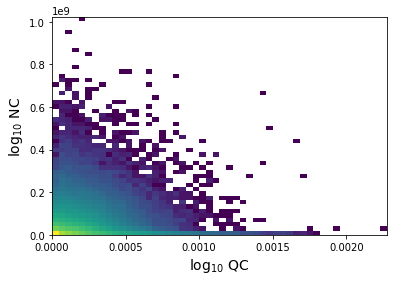

In [10]:
plt.hist2d(combined_input_data["QC_TAU_in"], combined_input_data["NC_TAU_in"], 
           bins=50, cmin=1, norm=LogNorm() )
plt.xlabel("$\log_{10}$ QC", fontsize=14)
plt.ylabel("$\log_{10}$ NC", fontsize=14)

In [11]:
dnn_qr = DenseNeuralNetwork(hidden_layers=6, hidden_neurons=30, 
                         inputs=len(input_cols), outputs=1, 
                         loss="mse", activation="selu", epochs=15, 
                         batch_size=256, verbose=1, lr=0.005)
dnn_nc = DenseNeuralNetwork(hidden_layers=6, hidden_neurons=30, 
                         inputs=len(input_cols), outputs=1, 
                         loss="mse", activation="selu", epochs=15, 
                         batch_size=256, verbose=1, l2_weight=0, lr=0.005)



In [12]:
input_transforms = {
    "QC_TAU_in": "log10_transform",
    "NC_TAU_in": "log10_transform",
    "QR_TAU_in": "log10_transform",
    "NR_TAU_in": "log10_transform"}

for var, transform_name in input_transforms.items():
    combined_input_data.loc[:, var] = transforms[transform_name](combined_input_data[var])


In [13]:
for var, transform_name in input_transforms.items():
    test_input_data.loc[:, var] = transforms[transform_name](test_input_data[var])

In [14]:
scaler = StandardScaler()
scaled_input_data = scaler.fit_transform(combined_input_data)

In [15]:
scaled_test_input = scaler.transform(test_input_data)

In [26]:
combined_output_data.columns

Index(['qctend_TAU', 'qrtend_TAU', 'nctend_TAU', 'nrtend_TAU'], dtype='object')

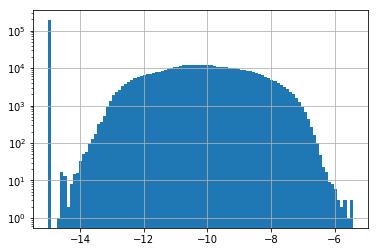

In [16]:
np.log10(np.maximum(1e-15, combined_output_data["qrtend_TAU"])).hist(bins=100)
plt.gca().set_yscale("log")

In [17]:
dnn_qr.fit(scaled_input_data, np.log10(np.maximum(1e-15, combined_output_data.iloc[:, 1])))

Epoch 1/15
671071/671071 [==============================] - 7s 10us/step - loss: 2.9688
Epoch 2/15
671071/671071 [==============================] - 6s 9us/step - loss: 0.9667
Epoch 3/15
671071/671071 [==============================] - 6s 9us/step - loss: 0.7143
Epoch 4/15
671071/671071 [==============================] - 6s 9us/step - loss: 0.6300
Epoch 5/15
671071/671071 [==============================] - 6s 9us/step - loss: 0.5910
Epoch 6/15
671071/671071 [==============================] - 6s 9us/step - loss: 0.5661
Epoch 7/15
671071/671071 [==============================] - 6s 9us/step - loss: 0.5510
Epoch 8/15
671071/671071 [==============================] - 6s 9us/step - loss: 0.5381
Epoch 9/15
671071/671071 [==============================] - 6s 9us/step - loss: 0.5258
Epoch 10/15
671071/671071 [==============================] - 6s 9us/step - loss: 0.5187
Epoch 11/15
671071/671071 [==============================] - 6s 9us/step - loss: 0.5112
Epoch 12/15
671071/671071 [=============

In [18]:
dnn_nc.fit(scaled_input_data, np.log10(np.maximum(-combined_output_data.iloc[:, 2], 1e-15)))

Epoch 1/15
671071/671071 [==============================] - 6s 10us/step - loss: 0.0504
Epoch 2/15
671071/671071 [==============================] - 6s 9us/step - loss: 0.0149
Epoch 3/15
671071/671071 [==============================] - 6s 9us/step - loss: 0.0134
Epoch 4/15
671071/671071 [==============================] - 6s 9us/step - loss: 0.0126
Epoch 5/15
671071/671071 [==============================] - 6s 9us/step - loss: 0.0121
Epoch 6/15
671071/671071 [==============================] - 6s 9us/step - loss: 0.0119
Epoch 7/15
671071/671071 [==============================] - 6s 9us/step - loss: 0.0116
Epoch 8/15
671071/671071 [==============================] - 6s 9us/step - loss: 0.0113
Epoch 9/15
671071/671071 [==============================] - 6s 9us/step - loss: 0.0110
Epoch 10/15
671071/671071 [==============================] - 6s 9us/step - loss: 0.0110
Epoch 11/15
671071/671071 [==============================] - 6s 9us/step - loss: 0.0108
Epoch 12/15
671071/671071 [=============

In [44]:
save_model(dnn_nc.model, "dnn_nc.h5")

In [55]:
dnn_nc.model.get_weights())

14

In [72]:
dnn_nc_ds = xr.open_dataset("dnn_nc.h5", group="model_weights/dense_9/dense_9")

In [79]:
dnn_nc_ds.variables["kernel:0"].values

array([[-2.97203541e-01, -4.70448099e-02, -5.30265132e-03,
         2.79997110e-01, -3.21283311e-01,  4.81324345e-01,
         3.23688649e-02, -3.07857513e-01, -3.21415544e-01,
        -8.90667140e-02,  3.04988056e-01, -1.95994884e-01,
         1.79581359e-01,  2.62557082e-02,  3.04079056e-01,
        -8.70043859e-02,  1.67601988e-01,  1.22479022e-01,
         2.78768748e-01,  7.65309036e-02,  2.40684479e-01,
        -2.10445493e-01, -2.89306454e-02, -6.51541576e-02,
        -2.51367632e-02,  1.56502157e-01, -1.22443140e-01,
         3.42928357e-02, -2.41874233e-01, -1.09926738e-01],
       [ 4.50381726e-01, -1.10439762e-01, -9.87639353e-02,
        -1.41558826e-01, -2.21303910e-01,  2.54540265e-01,
        -3.37306894e-02, -1.43744975e-01,  2.01814890e-01,
         3.02644163e-01, -1.14748001e-01,  2.60723472e-01,
         2.01815739e-01,  1.94684118e-01,  4.79827940e-01,
         3.58947277e-01, -1.69739276e-01,  2.41946474e-01,
        -2.37544123e-02, -3.02815348e-01, -2.06688493e-

In [19]:
nr_classifier = RandomForestClassifier(n_estimators=100, n_jobs=4, max_features="sqrt",
                                       verbose=1, class_weight="balanced_subsample")
nr_labels = np.zeros(combined_output_data.iloc[:, 3].shape, dtype=int)
nr_labels[combined_output_data.iloc[:, 3] > 0] = 1
nr_labels[combined_output_data.iloc[:, 3] < 0] = -1
subset = np.random.permutation(np.arange(0, nr_labels.shape[0]))[:100000]
nr_classifier.fit(scaled_input_data[subset], nr_labels[subset])

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    8.4s finished


RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=4, oob_score=False, random_state=None,
            verbose=1, warm_start=False)

In [20]:
feature_rankings = np.argsort(nr_classifier.feature_importances_)[::-1]
for rank in feature_rankings:
    print(input_cols[rank], nr_classifier.feature_importances_[rank])

QR_TAU_in 0.43647834223231163
NR_TAU_in 0.2138036221911074
QC_TAU_in 0.13372318268259648
NC_TAU_in 0.0642218470615368
temperature 0.055439802322720846
RHO_CLUBB_top 0.025861271455218094
pressure 0.02490181035661692
RHO_CLUBB_bottom 0.023789720627668296
RHO_CLUBB_lev 0.021780401070223818


In [21]:
test_nr_sign = nr_classifier.predict(scaled_test_input)

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    4.9s finished


In [22]:
test_nr_labels = np.zeros(test_output_data.iloc[:, 3].shape, dtype=int)
test_nr_labels[test_output_data.iloc[:, 3] > 0] = 1
test_nr_labels[test_output_data.iloc[:, 3] < 0] = -1
confusion_matrix(test_nr_labels, test_nr_sign)

array([[162519,    697,  11462],
       [   535, 267765,  13410],
       [  7482,  24066, 492157]])

In [23]:
nr_pos_net = DenseNeuralNetwork(hidden_layers=6, hidden_neurons=30, 
                         inputs=len(input_cols), outputs=1, 
                         loss="mse", activation="selu", epochs=15, 
                         batch_size=512, verbose=1, l2_weight=0, lr=0.005)
nr_neg_net = DenseNeuralNetwork(hidden_layers=6, hidden_neurons=30, 
                         inputs=len(input_cols), outputs=1, 
                         loss="mse", activation="selu", epochs=15, 
                         batch_size=512, verbose=1, l2_weight=0, lr=0.005)

In [80]:
pos_sub = combined_output_data.iloc[:, 3] > 0
neg_sub = combined_output_data.iloc[:, 3] < 0
nr_pos_net.fit(scaled_input_data[pos_sub], np.log10(combined_output_data.loc[pos_sub, "nrtend_TAU"]))
nr_neg_net.fit(scaled_input_data[neg_sub], np.log10(-combined_output_data.loc[neg_sub, "nrtend_TAU"]))

Epoch 1/15
361805/361805 [==============================] - 3s 9us/step - loss: 0.0679
Epoch 2/15
361805/361805 [==============================] - 3s 8us/step - loss: 0.0670
Epoch 3/15
361805/361805 [==============================] - 3s 8us/step - loss: 0.0666
Epoch 4/15
361805/361805 [==============================] - 3s 9us/step - loss: 0.0654
Epoch 5/15
361805/361805 [==============================] - 3s 9us/step - loss: 0.0654
Epoch 6/15
361805/361805 [==============================] - 3s 8us/step - loss: 0.0651
Epoch 7/15
361805/361805 [==============================] - 3s 8us/step - loss: 0.0635
Epoch 8/15
361805/361805 [==============================] - 3s 9us/step - loss: 0.0636
Epoch 9/15
361805/361805 [==============================] - 5s 14us/step - loss: 0.0634
Epoch 10/15
361805/361805 [==============================] - 5s 15us/step - loss: 0.0625
Epoch 11/15
361805/361805 [==============================] - 3s 7us/step - loss: 0.0623
Epoch 12/15
361805/361805 [============

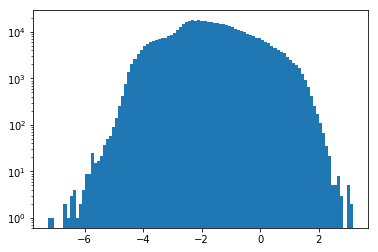

In [81]:
plt.hist(np.log10(test_output_data.loc[test_output_data["nrtend_TAU"] > 0, "nrtend_TAU"]), bins=100)
plt.gca().set_yscale("log")

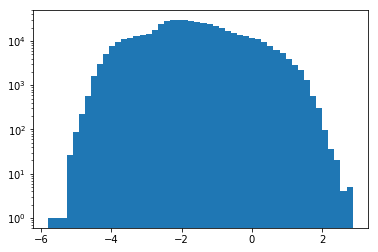

In [82]:
plt.hist(nr_pos_net.predict(scaled_test_input[test_nr_sign > 0]).ravel(), bins=50)
plt.gca().set_yscale("log")

In [83]:
nr_pred_values = np.zeros(scaled_test_input.shape[0])
nr_pred_values[test_nr_sign > 0] = 10 ** nr_pos_net.predict(scaled_test_input[test_nr_sign > 0]).ravel()
nr_pred_values[test_nr_sign < 0] = -10 ** nr_neg_net.predict(scaled_test_input[test_nr_sign < 0]).ravel()

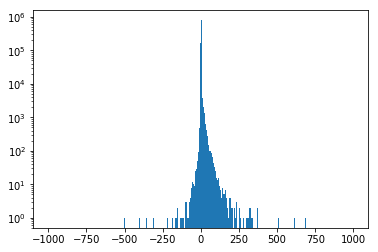

In [84]:
plt.hist(nr_pred_values, bins=np.arange(-1000, 1000, 5))
plt.gca().set_yscale("log")

In [39]:
pred_tendencies = pd.DataFrame(0, index=test_output_data.index, columns=output_cols[1:], dtype=float)
pred_tendencies.loc[:, "qrtend_TAU"] = dnn_qr.predict(scaled_test_input)
pred_tendencies.loc[:, "nctend_TAU"] = dnn_nc.predict(scaled_test_input)
pred_tendencies.loc[:, "nrtend_TAU"] = nr_pred_values


In [52]:
input_cols

['pressure',
 'temperature',
 'RHO_CLUBB_lev',
 'RHO_CLUBB_top',
 'RHO_CLUBB_bottom',
 'QC_TAU_in',
 'NC_TAU_in',
 'QR_TAU_in',
 'NR_TAU_in']

In [89]:
def partial_dependence_1d(x, model, var_index, var_vals):
    """
    Calculate how the mean prediction of an ML model varies if one variable's value is fixed across all input
    examples.

    Args:
        x: array of input variables
        model: scikit-learn style model object
        var_index: column index of the variable being investigated
        var_vals: values of the input variable that are fixed.

    Returns:
        Array of partial dependence values.
    """
    partial_dependence = np.zeros(var_vals.shape)
    x_copy = np.copy(x)
    for v, var_val in enumerate(var_vals):
        x_copy[:, var_index] = var_val
        partial_dependence[v] = model.predict(x_copy).mean()
    return partial_dependence

In [100]:
plt.hist(scaled_input_data[:, 9])

IndexError: index 9 is out of bounds for axis 1 with size 9

In [104]:
scaled_input_data.shape

(671071, 9)

In [129]:
pd_vals = np.linspace(-4, 4, 41)
pd_output_qr = np.zeros((len(input_cols), pd_vals.size))
subset = np.random.permutation(np.arange(scaled_input_data.shape[0]))[:20000]
for v, var in enumerate(input_cols):
    print(v, var)
    pd_output_qr[v] = partial_dependence_1d(scaled_input_data[subset], dnn_qr, v, pd_vals)

0 pressure
1 temperature
2 RHO_CLUBB_lev
3 RHO_CLUBB_top
4 RHO_CLUBB_bottom
5 QC_TAU_in
6 NC_TAU_in
7 QR_TAU_in
8 NR_TAU_in


In [131]:
pd_vals = np.linspace(-4, 4, 41)
pd_output_nc = np.zeros((len(input_cols), pd_vals.size))
for v, var in enumerate(input_cols):
    print(v, var)
    pd_output_nc[v] = partial_dependence_1d(scaled_input_data[subset], dnn_nc, v, pd_vals)

0 pressure
1 temperature
2 RHO_CLUBB_lev
3 RHO_CLUBB_top
4 RHO_CLUBB_bottom
5 QC_TAU_in
6 NC_TAU_in
7 QR_TAU_in
8 NR_TAU_in


In [132]:
pd_vals = np.linspace(-4, 4, 41)
pd_output_nr_pos = np.zeros((len(input_cols), pd_vals.size))
for v, var in enumerate(input_cols):
    print(v, var)
    pd_output_nr_pos[v] = partial_dependence_1d(scaled_input_data[subset], nr_pos_net, v, pd_vals)

0 pressure
1 temperature
2 RHO_CLUBB_lev
3 RHO_CLUBB_top
4 RHO_CLUBB_bottom
5 QC_TAU_in
6 NC_TAU_in
7 QR_TAU_in
8 NR_TAU_in


In [133]:
pd_vals = np.linspace(-4, 4, 41)
pd_output_nr_neg = np.zeros((len(input_cols), pd_vals.size))
for v, var in enumerate(input_cols):
    print(v, var)
    pd_output_nr_neg[v] = partial_dependence_1d(scaled_input_data[subset], nr_neg_net, v, pd_vals)

0 pressure
1 temperature
2 RHO_CLUBB_lev
3 RHO_CLUBB_top
4 RHO_CLUBB_bottom
5 QC_TAU_in
6 NC_TAU_in
7 QR_TAU_in
8 NR_TAU_in


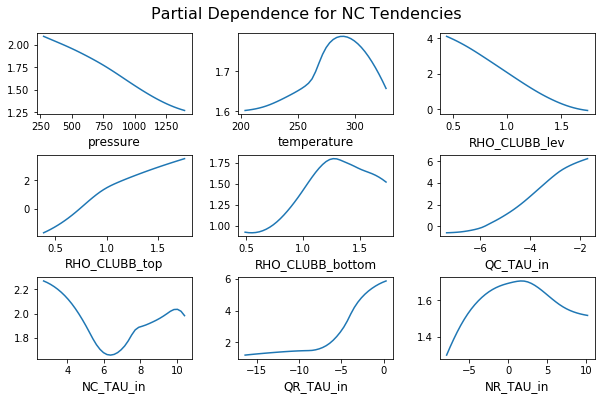

In [149]:
pd_unscaled = scaler.inverse_transform(np.tile(pd_vals.reshape(-1, 1), 9))
pd_unscaled[:, 0] = pd_unscaled[:, 0] / 100
fig, axes = plt.subplots(3, 3, figsize=(10, 6), sharey=False)
plt.subplots_adjust(hspace=0.5, wspace=0.3)
for a, ax in enumerate(axes.ravel()):
    ax.plot(pd_unscaled[:, a], pd_output_nc[a])

    ax.set_xlabel(input_cols[a], fontsize=12)
fig.suptitle("Partial Dependence for NC Tendencies", fontsize=16, y=0.94)
plt.savefig("pdp_nc.png", dpi=200, bbox_inches="tight")

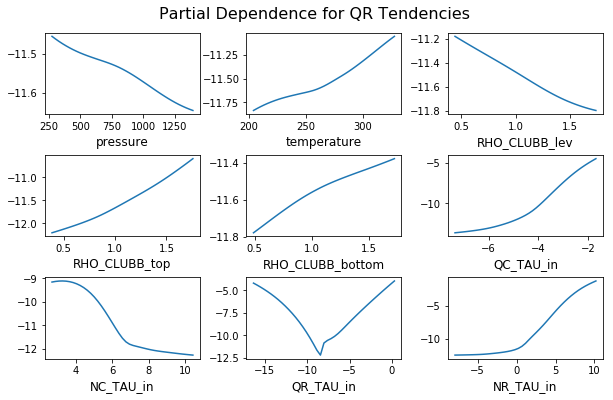

In [150]:
fig, axes = plt.subplots(3, 3, figsize=(10, 6), sharey=False)
plt.subplots_adjust(hspace=0.5, wspace=0.3)
for a, ax in enumerate(axes.ravel()):
    ax.plot(pd_unscaled[:, a], pd_output_qr[a])

    ax.set_xlabel(input_cols[a], fontsize=12)
fig.suptitle("Partial Dependence for QR Tendencies", fontsize=16, y=0.94)
plt.savefig("pdp_qr.png", dpi=200, bbox_inches="tight")

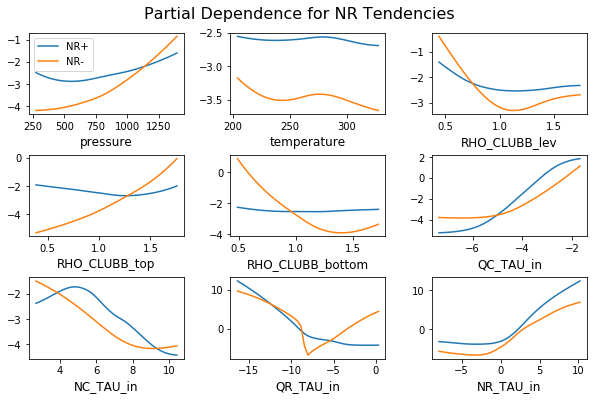

In [152]:
fig, axes = plt.subplots(3, 3, figsize=(10, 6), sharey=False)
plt.subplots_adjust(hspace=0.5, wspace=0.3)
for a, ax in enumerate(axes.ravel()):
        
    ax.plot(pd_unscaled[:, a], pd_output_nr_pos[a], label="NR+")
    ax.plot(pd_unscaled[:, a], pd_output_nr_neg[a], label="NR-")
    if a == 0:
        ax.legend()
    ax.set_xlabel(input_cols[a], fontsize=12)
fig.suptitle("Partial Dependence for NR Tendencies", fontsize=16, y=0.94)
plt.savefig("pdp_nr.png", dpi=200, bbox_inches="tight")

In [85]:
qr_percentiles = np.percentile(scaled_test_input[:, -2], np.arange(5, 100, 5))
nr_percentiles = np.percentile(scaled_test_input[:, -1], np.arange(5, 100, 5))
mean_pred = np.zeros((qr_percentiles.size - 1, nr_percentiles.size - 1))
for i in range(nr_percentiles.size - 1):
    for j in range(qr_percentiles.size - 1):
        shared_indices = np.where((scaled_test_input[:, -2] >= qr_percentiles[j]) &
                                  (scaled_test_input[:, -2] < qr_percentiles[j + 1]) &
                                  (scaled_test_input[:, -1] >= nr_percentiles[i]) &
                                  (scaled_test_input[:, -1] < nr_percentiles[i + 1])
                                 )[0]
        if shared_indices.size > 0:
            mean_pred[i, j] = nr_pred_values[shared_indices].mean()
        else:
            mean_pred[i, j] = np.nan

(array([[3.0877e+04, 1.0660e+03, 8.0700e+02, ...,        nan,        nan,
                nan],
        [2.0000e+00, 5.0000e+00, 1.3900e+02, ...,        nan,        nan,
                nan],
        [2.0000e+00, 4.0000e+00, 2.2000e+01, ...,        nan,        nan,
                nan],
        ...,
        [       nan,        nan,        nan, ..., 1.8000e+01,        nan,
         2.0000e+00],
        [       nan,        nan,        nan, ..., 1.0000e+00,        nan,
                nan],
        [       nan,        nan,        nan, ...,        nan,        nan,
                nan]]),
 array([-18.        , -17.68949921, -17.37899842, -17.06849762,
        -16.75799683, -16.44749604, -16.13699525, -15.82649445,
        -15.51599366, -15.20549287, -14.89499208, -14.58449129,
        -14.27399049, -13.9634897 , -13.65298891, -13.34248812,
        -13.03198733, -12.72148653, -12.41098574, -12.10048495,
        -11.78998416, -11.47948336, -11.16898257, -10.85848178,
        -10.54798099, -10

/Users/dgagne/miniconda3/envs/deep/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


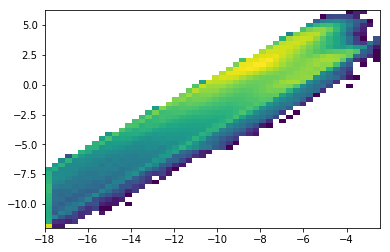

In [66]:
plt.hist2d(combined_input_data.iloc[:, -2], combined_input_data.iloc[:, -1], cmin=1, 
           bins=50, norm=LogNorm())

In [100]:
np.nanmin(mean_pred)

-0.0001874198589387655

Text(0,0.5,'NR')

/Users/dgagne/miniconda3/envs/deep/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


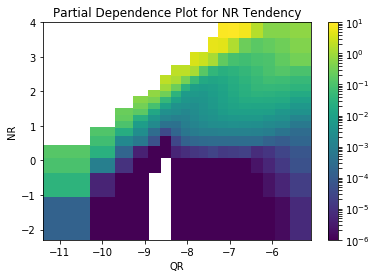

In [110]:
plt.pcolormesh(scaler.mean_[-2] + qr_percentiles * scaler.scale_[-2], 
               scaler.mean_[-1] + nr_percentiles * scaler.scale_[-1], np.abs(mean_pred),
               norm=LogNorm(1e-6, 10))
plt.colorbar()
plt.title("Partial Dependence Plot for NR Tendency")
plt.xlabel("QR")
plt.ylabel("NR")

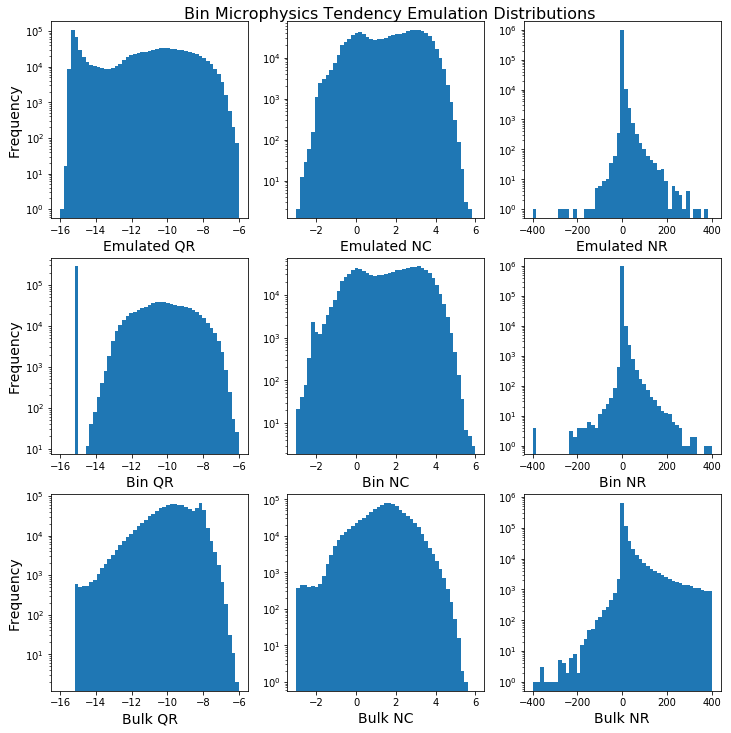

In [86]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
plt.subplots_adjust(0.03, 0.03, 0.96, 0.96, wspace=0.2)
all_bins = [np.linspace(-16, -6, 50), np.linspace(-3,6, 50), np.linspace(-400, 400, 50)]
axes[0, 0].hist(pred_tendencies.loc[:, "qrtend_TAU"],
             bins=all_bins[0])
axes[0, 0].set_xlabel("Emulated QR", fontsize=14)
axes[0, 0].set_yscale("log")
axes[0, 1].hist(pred_tendencies.loc[:, "nctend_TAU"], 
            bins=all_bins[1])
axes[0, 1].set_yscale("log")
axes[0, 1].set_xlabel("Emulated NC", fontsize=14)
axes[0, 2].hist(pred_tendencies.loc[:, "nrtend_TAU"], 
             bins=all_bins[2])
axes[0, 2].set_yscale("log")
axes[0, 2].set_xlabel("Emulated NR", fontsize=14)
axes[1, 0].hist(np.log10(np.maximum(1e-15, test_output_data.iloc[:, 1])),
             bins=all_bins[0])
axes[1, 0].set_yscale("log")
axes[1, 0].set_xlabel("Bin QR", fontsize=14)
axes[1, 1].hist(np.log10(np.maximum(1e-15, -test_output_data.iloc[:, 2])), 
            bins=all_bins[1])
axes[1, 1].set_yscale("log")
axes[1, 1].set_xlabel("Bin NC", fontsize=14)
axes[1, 2].hist(test_output_data.iloc[:, 3], 
             bins=all_bins[2])
axes[1, 2].set_yscale("log")
axes[1, 2].set_xlabel("Bin NR", fontsize=14)
axes[2, 0].hist(np.log10(np.maximum(1e-15, test_output_data["qrtend_MG2"])),
               bins=all_bins[0])
axes[2, 0].set_yscale("log")
axes[2, 0].set_xlabel("Bulk QR", fontsize=14)
axes[2, 1].hist(np.log10(np.maximum(1e-15, -test_output_data["nctend_MG2"])), 
            bins=all_bins[1])
axes[2, 1].set_yscale("log")
axes[2, 1].set_xlabel("Bulk NC", fontsize=14)
axes[2, 2].hist(test_output_data["nrtend_MG2"], 
             bins=all_bins[2])
axes[2, 2].set_yscale("log")
axes[2, 2].set_xlabel("Bulk NR", fontsize=14)
axes[0, 0].set_ylabel("Frequency", fontsize=14)
axes[1, 0].set_ylabel("Frequency", fontsize=14)
axes[2, 0].set_ylabel("Frequency", fontsize=14)
fig.suptitle("Bin Microphysics Tendency Emulation Distributions", y=0.98, fontsize=16)
plt.savefig("nn_bin_hist.png", dpi=200, bbox_inches="tight")

In [87]:
rmses = np.zeros(3)
rmses[0] = np.sqrt(mean_squared_error(np.log10(np.maximum(1e-15, test_output_data["qrtend_TAU"])), 
                                      pred_tendencies.loc[:, "qrtend_TAU"]))
rmses[1] = np.sqrt(mean_squared_error(np.log10(np.maximum(1e-15, -test_output_data["nctend_TAU"])), 
                                      pred_tendencies.loc[:, "nctend_TAU"]))
rmses[2] = np.sqrt(mean_squared_error(test_output_data["nrtend_TAU"], 
                                      pred_tendencies.loc[:, "nrtend_TAU"]))
r2s = np.zeros(3)
r2s[0] = r2_score(np.log10(np.maximum(1e-15, test_output_data["qrtend_TAU"])), 
                  pred_tendencies.loc[:, "qrtend_TAU"])
r2s[1] = r2_score(np.log10(np.maximum(1e-15, -test_output_data["nctend_TAU"])), 
                  pred_tendencies.loc[:, "nctend_TAU"])
r2s[2] = r2_score(test_output_data["nrtend_TAU"], 
                  pred_tendencies.loc[:, "nrtend_TAU"])

/Users/dgagne/miniconda3/envs/deep/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


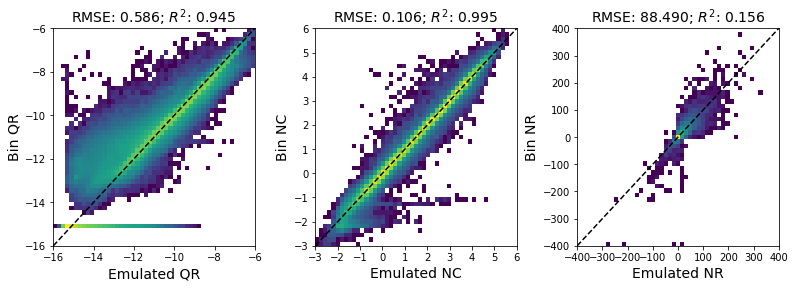

In [88]:
fig, axes = plt.subplots(1, 3, figsize=(13, 4))
plt.subplots_adjust(wspace=0.3)
axes[0].hist2d(pred_tendencies.loc[:, "qrtend_TAU"], 
               np.log10(np.maximum(1e-15, test_output_data.iloc[:, 1])),
               cmin=1, bins=all_bins[0], norm=LogNorm())
axes[0].set_xlabel("Emulated QR", fontsize=14)
axes[0].set_ylabel("Bin QR", fontsize=14)
axes[1].set_xticks(np.arange(-16, 7))
axes[1].set_yticks(np.arange(-16, 7))
axes[0].plot(np.arange(-16, 7),np.arange(-16, 7), 'k--')
axes[0].set_title("RMSE: {0:0.3f}; $R^2$: {1:0.3f}".format(rmses[0], r2s[0]), fontsize=14)
axes[1].hist2d(pred_tendencies.loc[:, "nctend_TAU"], 
               np.log10(np.maximum(1e-15, -test_output_data.iloc[:, 2])),
               cmin=1, bins=all_bins[1], norm=LogNorm())
axes[1].set_xlabel("Emulated NC", fontsize=14)
axes[1].set_ylabel("Bin NC", fontsize=14)
axes[1].set_title("RMSE: {0:0.3f}; $R^2$: {1:0.3f}".format(rmses[1], r2s[1]), fontsize=14)
axes[1].set_xticks(np.arange(-3, 7))
axes[1].set_yticks(np.arange(-3, 7))
axes[1].plot(np.arange(-3, 7),np.arange(-3, 7), 'k--')
axes[2].hist2d(pred_tendencies.loc[:, "nrtend_TAU"], 
               test_output_data.iloc[:, 3],
               cmin=1, bins=all_bins[2], norm=LogNorm())
axes[2].set_xlabel("Emulated NR", fontsize=14)
axes[2].set_ylabel("Bin NR", fontsize=14)
axes[2].set_title("RMSE: {0:0.3f}; $R^2$: {1:0.3f}".format(rmses[2], r2s[2]), fontsize=14)
axes[2].set_xticks(np.arange(-400, 500, 100))
axes[2].set_yticks(np.arange(-400, 500, 100))
axes[2].plot(np.arange(-400, 500, 100),np.arange(-400, 500, 100), 'k--')
plt.savefig("nn_bin_hist2d.png", dpi=200, bbox_inches="tight")

In [33]:
rmses_bulk = np.zeros(3)
rmses_bulk[0] = np.sqrt(mean_squared_error(np.log10(np.maximum(1e-15, test_output_data["qrtend_TAU"])), 
                                           np.log10(np.maximum(1e-15, test_output_data["qrtend_MG2"]))))
rmses_bulk[1] = np.sqrt(mean_squared_error(np.log10(np.maximum(1e-15, -test_output_data["nctend_TAU"])), 
                                           np.log10(np.maximum(1e-15, -test_output_data["nctend_MG2"]))))
rmses_bulk[2] = np.sqrt(mean_squared_error(test_output_data["nrtend_TAU"], 
                                           test_output_data["nrtend_MG2"]))
r2s_bulk = np.zeros(3)
r2s_bulk[0] = r2_score(np.log10(np.maximum(1e-15, test_output_data["qrtend_TAU"])), 
                  np.log10(np.maximum(1e-15, test_output_data["qrtend_MG2"])))
r2s_bulk[1] = r2_score(np.log10(np.maximum(1e-15, -test_output_data["nctend_TAU"])), 
                  np.log10(np.maximum(1e-15, -test_output_data["nctend_MG2"])))
r2s_bulk[2] = r2_score(test_output_data["nrtend_TAU"], 
                  test_output_data["nrtend_MG2"])

/Users/dgagne/miniconda3/envs/deep/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


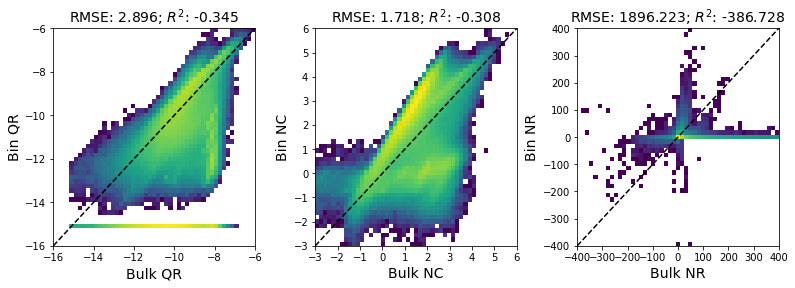

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(13, 4))
plt.subplots_adjust(wspace=0.3)
axes[0].hist2d(np.log10(np.maximum(1e-15, test_output_data["qrtend_MG2"])), 
               np.log10(np.maximum(1e-15, test_output_data.iloc[:, 1])),
               cmin=1, bins=all_bins[0], norm=LogNorm())
axes[0].set_xlabel("Bulk QR", fontsize=14)
axes[0].set_ylabel("Bin QR", fontsize=14)
axes[1].set_xticks(np.arange(-16, 7))
axes[1].set_yticks(np.arange(-16, 7))
axes[0].plot(np.arange(-16, 7),np.arange(-16, 7), 'k--')
axes[0].set_title("RMSE: {0:0.3f}; $R^2$: {1:0.3f}".format(rmses_bulk[0], r2s_bulk[0]), fontsize=14)
axes[1].hist2d(np.log10(-test_output_data["nctend_MG2"]), 
               np.log10(np.maximum(1e-15, -test_output_data.iloc[:, 2])),
               cmin=1, bins=all_bins[1], norm=LogNorm())
axes[1].set_xlabel("Bulk NC", fontsize=14)
axes[1].set_ylabel("Bin NC", fontsize=14)
axes[1].set_title("RMSE: {0:0.3f}; $R^2$: {1:0.3f}".format(rmses_bulk[1], r2s_bulk[1]), fontsize=14)
axes[1].set_xticks(np.arange(-3, 7))
axes[1].set_yticks(np.arange(-3, 7))
axes[1].plot(np.arange(-3, 7),np.arange(-3, 7), 'k--')
axes[2].hist2d(test_output_data["nrtend_MG2"], 
               test_output_data.iloc[:, 3],
               cmin=1, bins=all_bins[2], norm=LogNorm())
axes[2].set_xlabel("Bulk NR", fontsize=14)
axes[2].set_ylabel("Bin NR", fontsize=14)
axes[2].set_title("RMSE: {0:0.3f}; $R^2$: {1:0.3f}".format(rmses_bulk[2], r2s_bulk[2]), fontsize=14)
axes[2].set_xticks(np.arange(-400, 500, 100))
axes[2].set_yticks(np.arange(-400, 500, 100))
axes[2].plot(np.arange(-400, 500, 100),np.arange(-400, 500, 100), 'k--')
plt.savefig("nn_bulk_hist2d.png", dpi=200, bbox_inches="tight")